## Set Seed and TF Version for Reproducible results

In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
%env PYTHONHASHSEED=0

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

env: PYTHONHASHSEED=0


/Users/peterkruse/Desktop/proj/my_env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Necessary Packages

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, Conv1DTranspose, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ReLU, Masking, Concatenate, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Zeros
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
#add data directory to path
os.chdir(os.getcwd() + '/Data/')


## Load LEfSe Data

In [4]:
#metadata
meta = pd.read_csv("cdiff_meta_COMBINED.txt", sep = "\t")

#combined species datasets
all_species = pd.read_csv("norm_filtered_species_table-NEW.txt", sep = "\t")

#lefse names
species_lefse = pd.read_csv("ALL-SPECIES-species-ed_lefse_CDIStatus-k2-full.txt.2.txt", sep = "\t")

#combined datasets
all_genes = pd.read_csv("norm_table-hits-genes-NEW.txt", sep = "\t")

#lefse gene names
genes_lefse = pd.read_csv("ALL-GENES-renamed_lefse_CDIStatus-emapper-full.txt", sep = "\t")

## Preprocess Species Data

In [5]:
#change all name separators to '_'
lefse_names = []
for name in species_lefse["Species"]:
    name = re.sub("[^0-9a-zA-Z]+", "_", name)
    lefse_names.append(name)

In [6]:
# transpose bacteria data
all_species = all_species.set_index("SampleID")
all_species = all_species.transpose()

In [7]:
# get sample indexes
sample_ids = list(all_species.index)

In [8]:
# sort by index
all_species.index = all_species.index.map(int)
all_species = all_species.sort_index()
all_species.astype("float32")

SampleID,d__Archaea;p__Candidatus_Korarchaeota;g__Candidatus_Korarchaeum;s__Candidatus_Korarchaeum_cryptofilum,d__Archaea;p__Candidatus_Lokiarchaeota;g__Candidatus_Prometheoarchaeum;s__Candidatus_Prometheoarchaeum_syntrophicum,d__Archaea;p__Candidatus_Micrarchaeota;g__Candidatus_Mancarchaeum;s__Candidatus_Mancarchaeum_acidiphilum,d__Archaea;p__Candidatus_Micrarchaeota;g__Candidatus_Micrarchaeum;s__Candidatus_Micrarchaeum_sp.,d__Archaea;p__Candidatus_Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Candidatus_Methanomethylophilaceae;g__Candidatus_Methanomethylophilus;s__Candidatus_Methanomethylophilus_alvus,d__Archaea;p__Candidatus_Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Candidatus_Methanoplasma;s__Candidatus_Methanoplasma_termitum,d__Archaea;p__Candidatus_Thermoplasmatota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus;s__Candidatus_Methanomassiliicoccus_intestinalis,d__Archaea;p__Candidatus_Thermoplasmatota;c__Thermoplasmata;o__Thermoplasmatales;f__Cuniculiplasmataceae;g__Cuniculiplasma;s__Cuniculiplasma_divulgatum,d__Archaea;p__Candidatus_Thermoplasmatota;c__Thermoplasmata;o__Thermoplasmatales;f__Ferroplasmaceae;g__Ferroplasma;s__Ferroplasma_acidarmanus,d__Archaea;p__Candidatus_Thermoplasmatota;c__Thermoplasmata;o__Thermoplasmatales;f__Picrophilaceae;g__Picrophilus;s__Picrophilus_torridus,...,d__Viruses;s__Hubei_diptera_virus_10,d__Viruses;s__Hubei_noda-like_virus_9,d__Viruses;s__Hubei_picorna-like_virus_13,d__Viruses;s__Hubei_tombus-like_virus_30,d__Viruses;s__Leptopilina_boulardi_filamentous_virus,d__Viruses;s__Mollivirus_sibericum,d__Viruses;s__Pacmanvirus_A23,d__Viruses;s__Shuangao_Bedbug_Virus_2,d__Viruses;s__Wuhan_nido-like_virus_1,d__Viruses;s__uncultured_Mediterranean_phage
1,0.000000,0.128367,0.000000,0.0,0.128367,0.000000,0.128367,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.148030,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,7.531320,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.520105,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.086684,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.589833,0.000000,0.0,0.000000,0.000000,0.235933,0.000000,0.0,0.117967,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.539030,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,52.159401,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.138867,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.138867,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.137250,0.000000,0.0,0.137250,0.137250,0.411751,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.137250,0.000000,0.000000,0.000000,0.000000
10,0.000000,1.742960,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
#change all name separators to '_'
new_col_names = []
for name in all_species.columns:
    name = re.sub("[^0-9a-zA-Z]+", "_", name)
    new_col_names.append(name)
    
all_species.columns = new_col_names

In [10]:
# subset with lefse selected species names
all_species_lefse = all_species[lefse_names]

In [11]:
# check shape of data (num rows, num cols)
all_species_lefse.shape

(39, 222)

In [12]:
#get corresponding metadata output vector
meta = meta[meta["SampleID"].isin(sample_ids)]
# make output vector (positive/negative) from metadata
y = [1 if i == 'Positive' else 0 for i in meta["CDIStatus"]]
y = np.array(y)
y = y.astype("float32")

In [13]:
# check output shape (should be same as num rows)
y.shape

(39,)

In [14]:
# make C. diff. removed datasets
c_diff_col = [col for col in all_species.columns if 'Clostridioides_difficile' in col]
all_species_no_c_diff = all_species.drop(c_diff_col, axis=1)
all_species_lefse_no_c_diff = all_species_lefse.drop(c_diff_col, axis=1)

In [15]:
#check shapes (should be 1 less col than original shapes)
print(all_species_no_c_diff.shape)
print(all_species_lefse_no_c_diff.shape)

(39, 7378)
(39, 221)


## Preprocess Gene Data

In [16]:
# transpose combined data
all_genes = all_genes.set_index("SampleID")
all_genes = all_genes.transpose()
all_genes.index = all_genes.index.map(int)
all_genes = all_genes.sort_index()

In [17]:
#view dataset and print shape
print(all_genes.shape)
all_genes.head()

(39, 8002)


SampleID,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,K00009,K00010,...,K22486,K22488,K22491,K22493,K22494,K22502,K22504,K22506,K22511,K22514
1,228.1470,19.2167,145.418,0.0000,75.5143,0.000,0.0,362.816,130.689,78.45220,...,0.0,0.0,0.0,0.00000,0.0000,0.0,0.0,0.00000,0.0,0.0
2,98.0316,0.0000,213.130,67.1364,99.1754,11.928,0.0,285.134,104.414,0.00000,...,0.0,0.0,0.0,10.27340,0.0000,0.0,0.0,0.00000,0.0,0.0
3,268.7630,0.0000,360.945,0.0000,0.0000,0.000,0.0,819.769,117.328,14.67680,...,0.0,0.0,0.0,0.00000,0.0000,0.0,0.0,0.00000,0.0,0.0
4,123.8800,22.0256,266.760,16.9542,22.4001,90.657,0.0,178.543,374.525,3.82086,...,0.0,0.0,0.0,6.22126,4.5493,0.0,0.0,0.00000,0.0,0.0
5,159.3320,0.0000,257.006,13.9897,81.1598,0.000,0.0,223.322,302.962,26.93170,...,0.0,0.0,0.0,0.00000,0.0000,0.0,0.0,2.27226,0.0,0.0


In [18]:
# create lefse gene dataset and check shape
lefse_genes = all_genes[genes_lefse["GeneID"]]
lefse_genes.shape

(39, 130)

# Test Models on All Species

Scores for each fold are: [0.75       1.         0.5        0.5        0.75       0.5
 0.75       0.5        0.75       0.66666667 0.75       0.75
 0.75       0.5        0.75       1.         0.75       1.
 0.5        0.33333333 0.5        0.75       0.25       0.75
 0.75       0.75       0.5        1.         0.75       1.
 1.         0.5        1.         0.5        0.75       0.5
 0.75       0.75       0.75       0.66666667 1.         0.75
 0.5        0.5        0.25       1.         0.75       1.
 0.5        0.66666667]
Average score: 0.697


<Axes: >

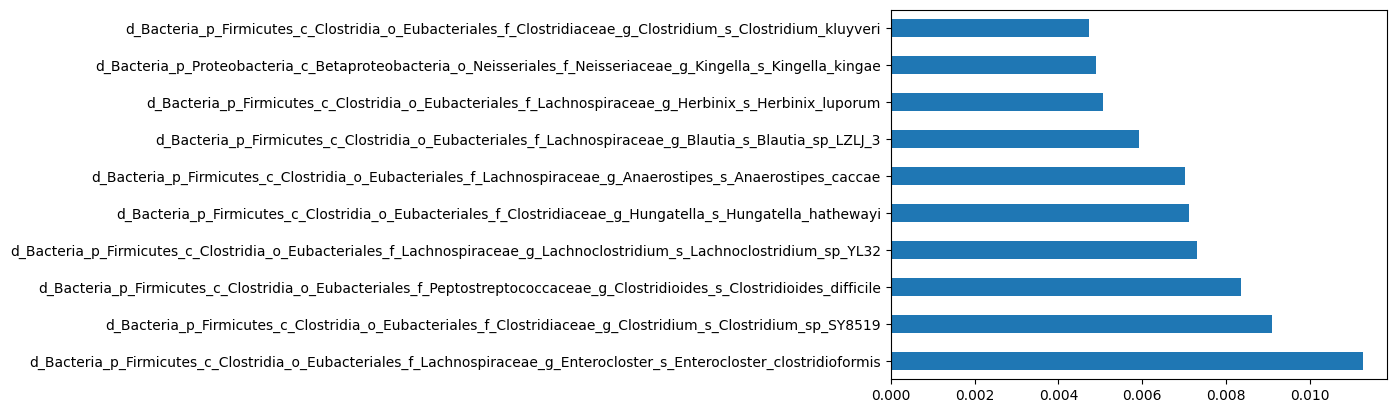

In [22]:
#RF
clf = RandomForestClassifier(n_estimators=500)
clf.fit(all_species, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=all_species.columns).nlargest(10).plot(kind='barh')

Text(0.5, 1.0, 'Random Forest Feature Importance for All Species')

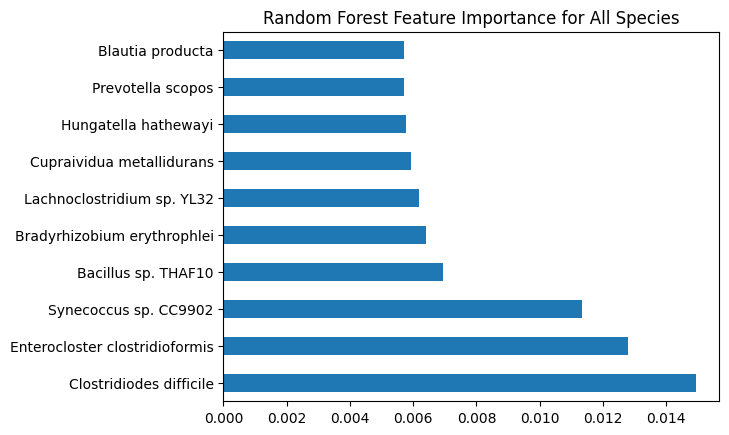

In [21]:
names = ['Clostridiodes difficile',
         'Enterocloster clostridioformis',
         'Synecoccus sp. CC9902',
         'Bacillus sp. THAF10',
         'Bradyrhizobium erythrophlei',
         'Lachnoclostridium sp. YL32',
         'Cupraividua metallidurans',
         'Hungatella hathewayi',
         'Prevotella scopos',
         'Blautia producta']

p = pd.Series(abs(clf.feature_importances_), index=all_species.columns).nlargest(10).plot(kind='barh')
p.set_yticklabels(names)
plt.title("Random Forest Feature Importance for All Species")

Scores for each fold are: [0.75       0.5        0.25       0.75       1.         0.75
 0.5        0.5        0.5        0.66666667 0.75       0.5
 0.5        0.25       1.         0.5        0.75       0.75
 0.5        0.66666667 0.5        0.75       0.75       0.75
 1.         0.5        1.         0.5        0.5        0.66666667
 0.5        0.75       0.75       0.75       0.75       0.25
 0.75       1.         0.75       0.66666667 1.         0.75
 0.75       0.5        0.25       0.         0.25       0.5
 0.75       1.        ]
Average score: 0.638


<Axes: >

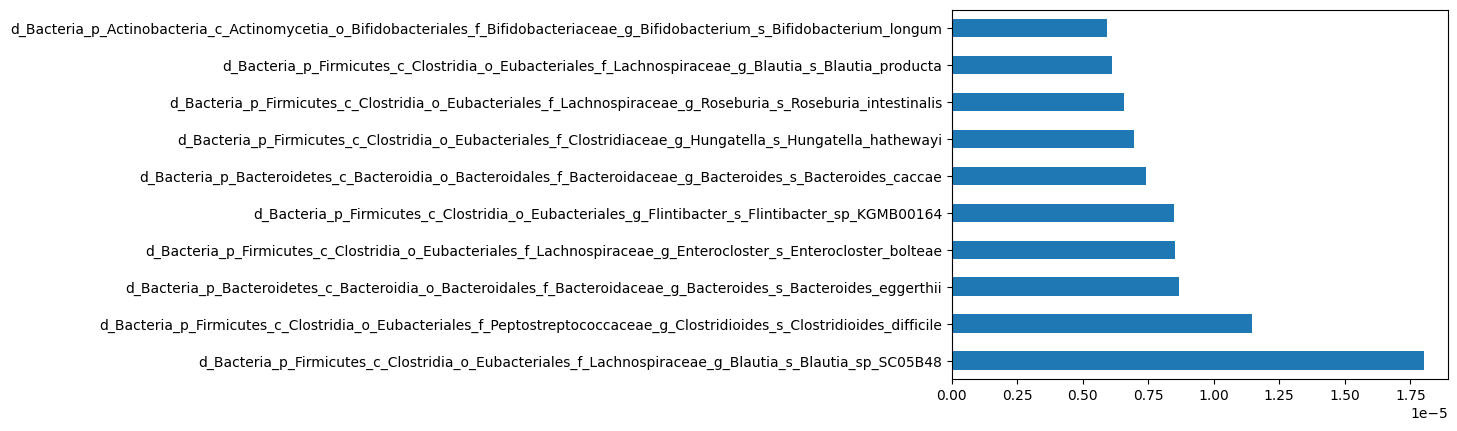

In [23]:
#SVM
from sklearn import svm
from sklearn import metrics

clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(all_species, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=all_species.columns).nlargest(10).plot(kind='barh')

In [24]:
#ANN
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(all_species, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(all_species.iloc[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(all_species.iloc[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(all_species.iloc[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 88.89% 
train binary_accuracy: 91.43%

auc: 50.00% 
binary_accuracy: 75.00% 

train auc: 88.89% 
train binary_accuracy: 85.71%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 89.22% 
train binary_accuracy: 94.29%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 86.76% 
train binary_accuracy: 54.29%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 90.36% 
train binary_accuracy: 77.14%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 94.77% 
train binary_accuracy: 91.43%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 99.67% 
train binary_accuracy: 97.14%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 25.00% 
binary_accuracy: 50.00% 

train auc: 83.66% 
train binary_accuracy: 85.71%

auc: 25.00% 
binary_accuracy: 50.00% 

train auc: 93.83% 
train binary_accuracy: 83.33%

auc: 100.00% 
binary_accuracy: 66.67% 

Accuracy: 51.67% (+/-12.25%) 
AUC: 50.00% (+/-19.36%)


# Test Models on Lefse Identified Species

Scores for each fold are: [1.         1.         0.75       0.5        0.75       0.75
 1.         0.5        1.         0.66666667 1.         1.
 0.75       1.         1.         1.         0.75       1.
 1.         0.66666667 0.75       1.         0.5        1.
 1.         1.         0.5        0.75       0.75       1.
 1.         0.75       1.         0.75       0.75       1.
 1.         0.75       0.5        1.         0.75       1.
 1.         1.         0.75       1.         1.         1.
 0.75       0.33333333]
Average score: 0.848


<Axes: >

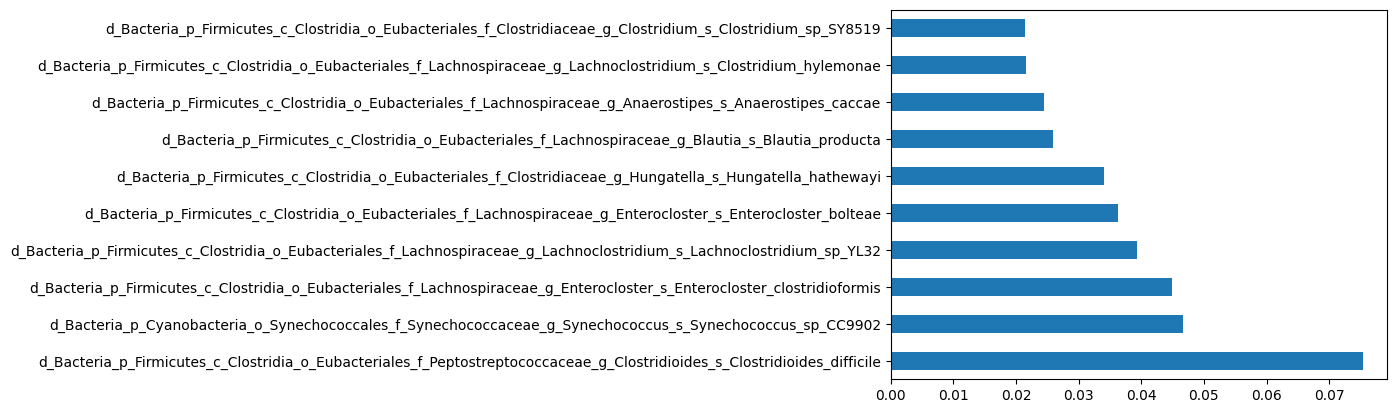

In [25]:
#RF
clf = RandomForestClassifier(n_estimators=500)
clf.fit(all_species_lefse, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species_lefse, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=all_species_lefse.columns).nlargest(10).plot(kind='barh')

In [ ]:
# change names in plot 


NameError: name 'plt' is not defined

Scores for each fold are: [0.75       1.         0.5        0.75       1.         0.75
 1.         0.5        1.         1.         0.75       1.
 0.75       0.75       0.75       1.         0.75       1.
 0.75       0.66666667 1.         0.75       0.75       1.
 1.         0.75       1.         0.75       0.5        1.
 1.         0.75       1.         0.75       0.75       0.75
 1.         1.         0.75       0.66666667 0.75       0.75
 1.         1.         0.5        0.75       0.75       1.
 0.75       1.        ]
Average score: 0.832


<Axes: >

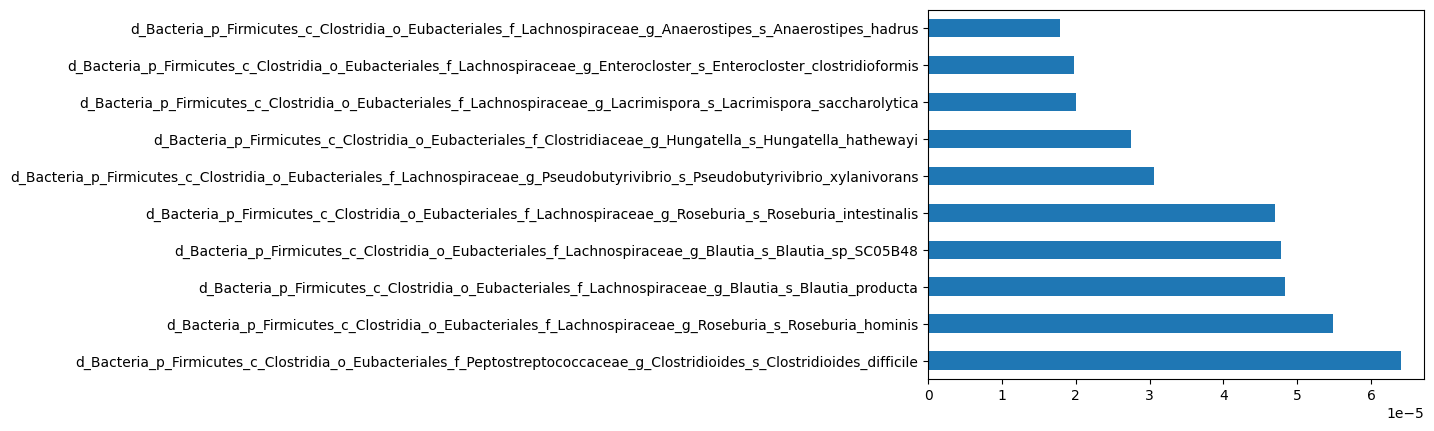

In [ ]:
#SVM
clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(all_species_lefse, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species_lefse, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=all_species_lefse.columns).nlargest(10).plot(kind='barh')

In [ ]:
#ANN
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(all_species_lefse, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(all_species_lefse.iloc[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(all_species_lefse.iloc[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(all_species_lefse.iloc[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 75.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 94.29%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 62.50% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 91.43%

auc: 100.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 75.00% 
binary_accuracy: 75.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 100.00% 
binary_accuracy: 100.00% 

Accuracy: 82.50% (+/-22.50%) 
AUC: 91.25% (+/-13.75%)


# Test Models on All Species, excluding C. difficile

Scores for each fold are: [0.75       1.         0.5        0.75       0.5        0.75
 0.75       0.5        0.75       0.66666667 0.75       0.75
 0.75       0.25       0.75       1.         0.75       1.
 0.5        0.33333333 0.5        0.75       0.5        0.75
 0.75       0.75       0.5        0.75       0.75       1.
 1.         0.75       0.75       0.5        0.75       0.5
 0.75       0.75       0.75       0.66666667 1.         0.75
 0.75       0.75       0.25       1.         0.75       1.
 1.         0.66666667]
Average score: 0.717


<Axes: >

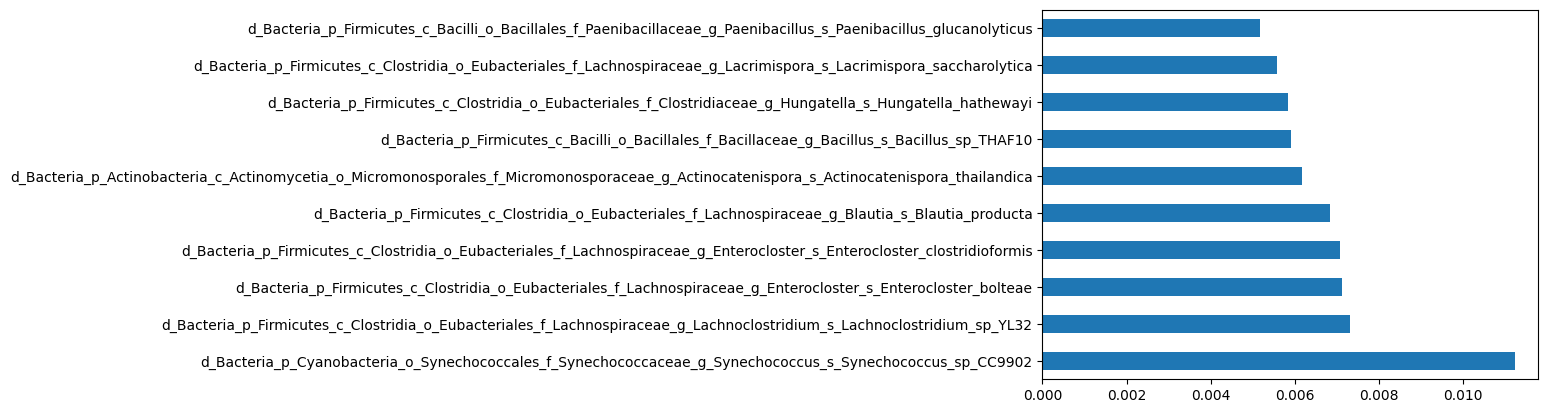

In [ ]:
#RF
clf = RandomForestClassifier(n_estimators=500)
clf.fit(all_species_no_c_diff, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species_no_c_diff, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=all_species_no_c_diff.columns).nlargest(10).plot(kind='barh')

Scores for each fold are: [0.5        0.25       0.25       0.75       0.75       0.5
 0.5        0.25       0.25       0.66666667 0.25       0.5
 0.5        0.25       0.75       0.5        0.75       0.75
 0.5        1.         0.5        0.5        0.75       0.75
 0.75       0.5        0.75       0.5        0.5        0.66666667
 0.5        0.5        0.5        0.75       0.75       0.25
 0.5        0.75       0.75       0.66666667 0.5        0.5
 0.5        0.75       0.25       0.         0.25       0.5
 0.75       1.        ]
Average score: 0.550


<Axes: >

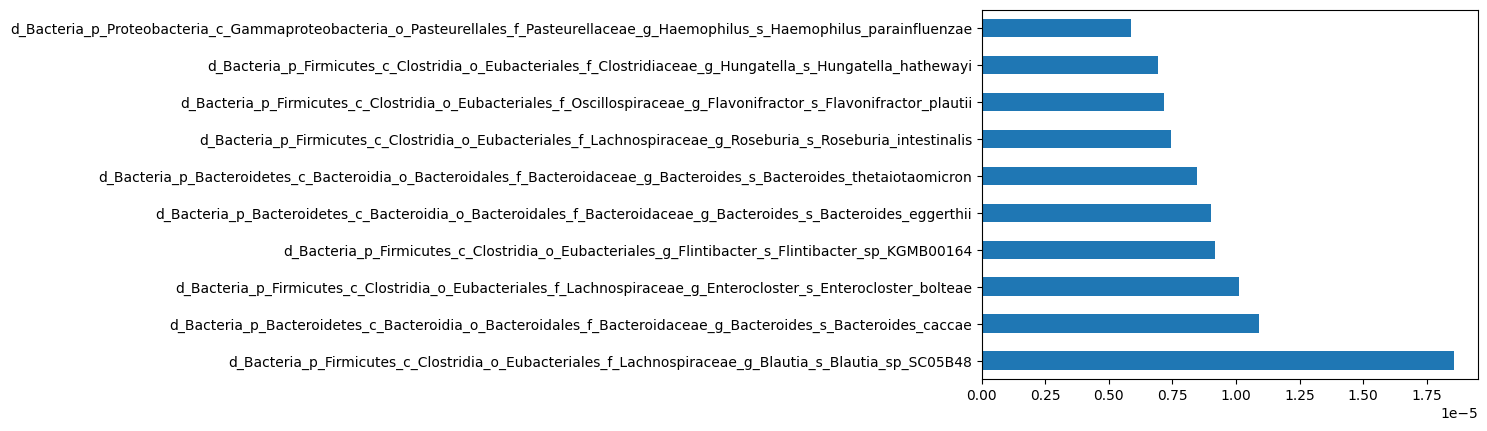

In [ ]:
#SVM
clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(all_species_no_c_diff, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species_no_c_diff, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=all_species_no_c_diff.columns).nlargest(10).plot(kind='barh')

In [ ]:
#ANN
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(all_species_no_c_diff, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(all_species_no_c_diff.iloc[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(all_species_no_c_diff.iloc[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(all_species_no_c_diff.iloc[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 88.89% 
train binary_accuracy: 68.57%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 87.09% 
train binary_accuracy: 88.57%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 93.63% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 79.74% 
train binary_accuracy: 82.86%

auc: 25.00% 
binary_accuracy: 50.00% 

train auc: 78.92% 
train binary_accuracy: 80.00%

auc: 50.00% 
binary_accuracy: 75.00% 

train auc: 98.69% 
train binary_accuracy: 80.00%

auc: 25.00% 
binary_accuracy: 50.00% 

train auc: 95.59% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 99.02% 
train binary_accuracy: 88.57%

auc: 50.00% 
binary_accuracy: 25.00% 

train auc: 82.03% 
train binary_accuracy: 80.00%

auc: 25.00% 
binary_accuracy: 50.00% 

train auc: 99.07% 
train binary_accuracy: 94.44%

auc: 0.00% 
binary_accuracy: 66.67% 

Accuracy: 46.67% (+/-16.33%) 
AUC: 37.50% (+/-16.77%)


# Test Models on Lefse Identified Species, excluding C. difficile

Scores for each fold are: [1.         1.         0.75       0.5        0.75       0.75
 1.         0.5        0.75       0.33333333 1.         0.75
 0.75       0.75       0.75       0.75       0.5        1.
 0.75       0.33333333 1.         1.         0.5        0.75
 1.         1.         0.5        0.75       1.         1.
 1.         0.5        0.75       1.         0.75       0.75
 1.         0.75       0.5        1.         0.75       0.75
 0.75       0.75       0.75       1.         1.         1.
 0.5        0.33333333]
Average score: 0.775


<Axes: >

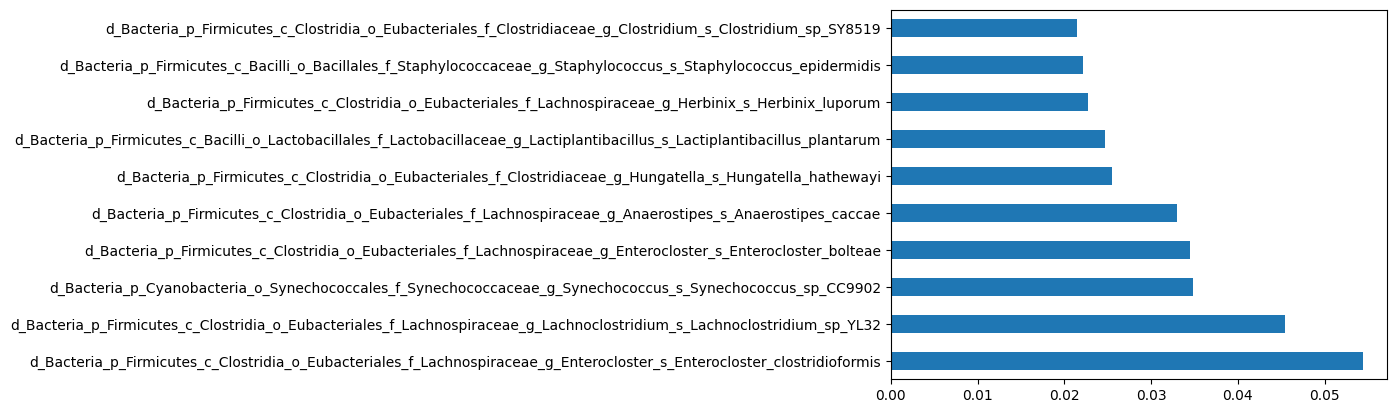

In [ ]:
#RF
clf = RandomForestClassifier(n_estimators=500)
clf.fit(all_species_lefse_no_c_diff, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species_lefse_no_c_diff, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=all_species_lefse_no_c_diff.columns).nlargest(10).plot(kind='barh')

Scores for each fold are: [0.75       1.         0.75       0.75       0.75       0.25
 1.         0.5        1.         1.         0.75       1.
 0.75       1.         1.         1.         0.5        0.75
 0.75       0.33333333 1.         0.75       0.75       0.75
 1.         1.         0.5        0.75       0.5        0.66666667
 1.         0.75       1.         1.         1.         0.75
 0.5        0.5        0.75       0.66666667 1.         0.75
 1.         0.5        0.75       0.75       1.         0.75
 0.75       0.66666667]
Average score: 0.782


<Axes: >

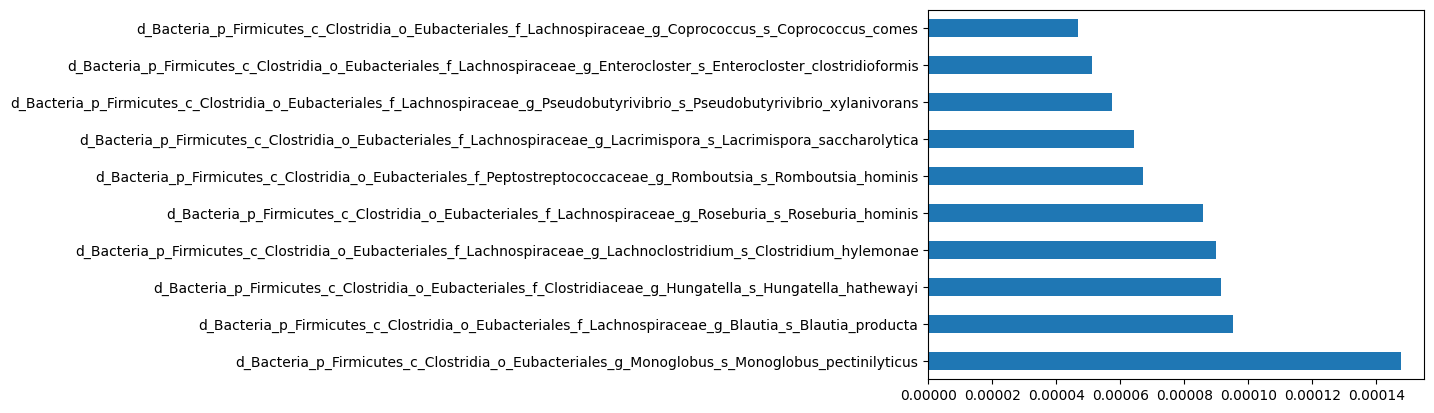

In [ ]:
#SVM
clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(all_species_lefse_no_c_diff, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_species_lefse_no_c_diff, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=all_species_lefse_no_c_diff.columns).nlargest(10).plot(kind='barh')

In [ ]:
#ANN
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(all_species_lefse_no_c_diff, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(all_species_lefse_no_c_diff.iloc[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(all_species_lefse_no_c_diff.iloc[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(all_species_lefse_no_c_diff.iloc[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 62.50% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 94.29%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 88.57%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 100.00% 
binary_accuracy: 75.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 100.00% 
train binary_accuracy: 100.00%

auc: 100.00% 
binary_accuracy: 100.00% 

Accuracy: 82.50% (+/-22.50%) 
AUC: 86.25% (+/-21.25%)


# Test Models on All Genes

Scores for each fold are: [0.75       1.         0.25       1.         0.75       0.75
 1.         0.5        1.         0.66666667 0.75       0.75
 0.75       0.5        1.         1.         0.75       1.
 0.5        0.66666667 0.75       0.75       0.75       0.75
 1.         0.75       0.75       0.5        0.75       1.
 1.         0.75       0.75       0.75       1.         0.25
 0.75       1.         0.75       1.         1.         0.75
 1.         0.75       0.5        1.         0.75       1.
 0.75       1.        ]
Average score: 0.792


<Axes: ylabel='SampleID'>

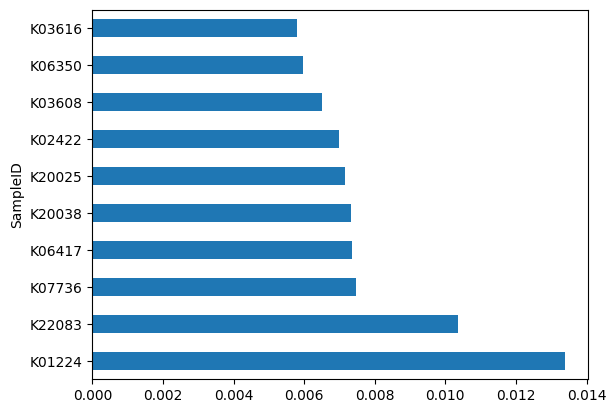

In [ ]:
#RF
clf = RandomForestClassifier(n_estimators=500)
clf.fit(all_genes, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_genes, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=all_genes.columns).nlargest(10).plot(kind='barh')

Scores for each fold are: [0.75       0.5        0.         1.         0.75       0.75
 0.75       0.5        0.75       0.         0.5        0.5
 1.         0.5        0.75       1.         0.75       1.
 0.25       0.33333333 0.75       0.75       0.5        0.75
 0.5        0.5        0.5        0.75       0.5        0.66666667
 1.         0.75       0.75       0.25       0.5        0.25
 0.75       1.         0.5        0.33333333 1.         0.75
 0.75       0.25       0.5        0.25       0.5        0.75
 0.75       1.        ]
Average score: 0.622


<Axes: ylabel='SampleID'>

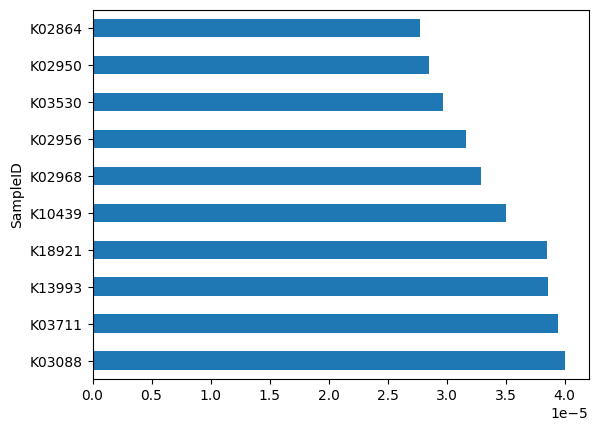

In [ ]:
#SVM
clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(all_genes, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, all_genes, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=all_genes.columns).nlargest(10).plot(kind='barh')

In [ ]:
#ANN
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(all_genes, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(all_genes.iloc[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(all_genes.iloc[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(all_genes.iloc[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 87.91% 
train binary_accuracy: 80.00%

auc: 75.00% 
binary_accuracy: 75.00% 

train auc: 93.63% 
train binary_accuracy: 88.57%

auc: 100.00% 
binary_accuracy: 75.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 0.00% 
binary_accuracy: 25.00% 

train auc: 95.10% 
train binary_accuracy: 82.86%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 95.26% 
train binary_accuracy: 82.86%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 95.59% 
train binary_accuracy: 91.43%

auc: 75.00% 
binary_accuracy: 50.00% 

train auc: 93.63% 
train binary_accuracy: 85.71%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 95.92% 
train binary_accuracy: 94.29%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 90.69% 
train binary_accuracy: 82.86%

auc: 100.00% 
binary_accuracy: 75.00% 

train auc: 94.44% 
train binary_accuracy: 91.67%

auc: 100.00% 
binary_accuracy: 66.67% 

Accuracy: 71.67% (+/-23.63%) 
AUC: 80.00% (+/-31.22%)


# Test Models on Lefse Identified Genes

Scores for each fold are: [0.75       1.         0.5        1.         1.         0.75
 1.         0.5        1.         1.         0.5        1.
 0.75       0.75       1.         1.         1.         1.
 0.75       0.66666667 1.         0.75       0.75       0.75
 1.         0.75       1.         0.75       0.75       1.
 1.         1.         0.75       0.75       1.         0.5
 0.5        1.         0.75       1.         1.         0.75
 1.         0.75       0.5        1.         0.75       1.
 0.75       0.66666667]
Average score: 0.837


<Axes: ylabel='SampleID'>

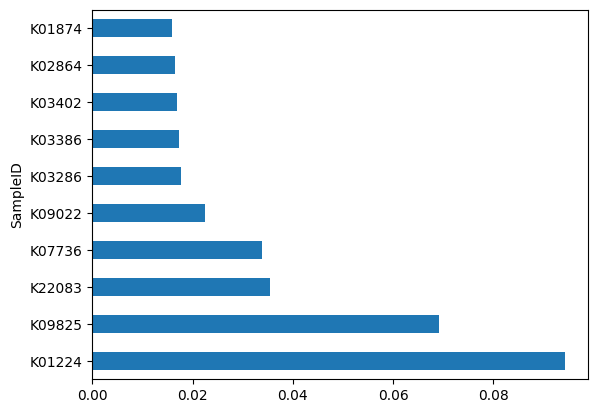

In [ ]:
#RF
clf = RandomForestClassifier(n_estimators=500)
clf.fit(lefse_genes, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, lefse_genes, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=lefse_genes.columns).nlargest(10).plot(kind='barh')

Scores for each fold are: [0.75       0.5        0.25       0.75       0.5        0.75
 0.75       0.         0.75       1.         0.5        0.75
 0.75       0.5        0.75       1.         0.5        0.75
 0.5        0.33333333 1.         0.5        1.         0.75
 0.25       0.75       0.75       0.5        0.5        1.
 0.75       1.         0.5        0.         0.75       0.5
 0.75       1.         0.25       0.66666667 0.75       0.5
 1.         0.5        0.25       0.75       0.5        0.5
 0.75       1.        ]
Average score: 0.640


<Axes: ylabel='SampleID'>

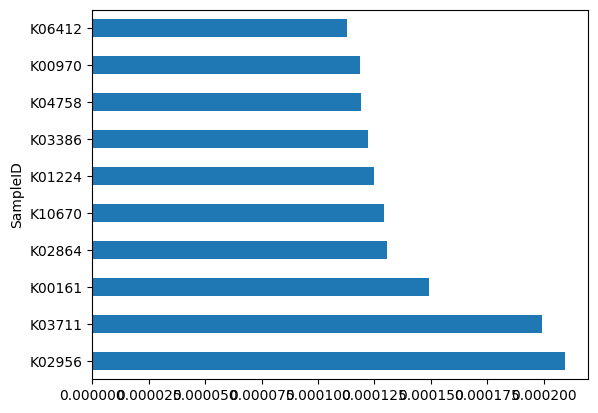

In [ ]:
#SVM
clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(lefse_genes, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, lefse_genes, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.coef_[0]), index=lefse_genes.columns).nlargest(10).plot(kind='barh')

In [ ]:
#ANN
# Begin K-fold Cross-Validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(lefse_genes, y):
    
    model = Sequential([
        Dense(1000, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["AUC", "binary_accuracy"])
    
    model.fit(lefse_genes.iloc[train], y[train],
              epochs = 100,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(lefse_genes.iloc[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} \ntrain {:s}: {:.2%}".format(model.metrics_names[1], train_result[1],
                                               model.metrics_names[2], train_result[2]))
    
    result = model.evaluate(lefse_genes.iloc[test], y[test], verbose = 0)
    print("\n{:s}: {:.2%} \n{:s}: {:.2%} \n".format(model.metrics_names[1], result[1],
                                               model.metrics_names[2], result[2]))
    cvacc.append(result[2])
    cvauc.append(result[1])
print("Accuracy: {:.2%} (+/-{:.2%}) \nAUC: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc),
                                                      np.mean(cvauc), np.std(cvauc)))

train auc: 99.67% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 99.51% 
train binary_accuracy: 82.86%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 82.86%

auc: 25.00% 
binary_accuracy: 25.00% 

train auc: 97.88% 
train binary_accuracy: 91.43%

auc: 100.00% 
binary_accuracy: 100.00% 

train auc: 97.88% 
train binary_accuracy: 65.71%

auc: 62.50% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 85.71%

auc: 50.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 97.14%

auc: 100.00% 
binary_accuracy: 50.00% 

train auc: 100.00% 
train binary_accuracy: 91.43%

auc: 25.00% 
binary_accuracy: 25.00% 

train auc: 100.00% 
train binary_accuracy: 91.43%

auc: 100.00% 
binary_accuracy: 75.00% 

train auc: 98.15% 
train binary_accuracy: 91.67%

auc: 100.00% 
binary_accuracy: 66.67% 

Accuracy: 54.17% (+/-21.16%) 
AUC: 66.25% (+/-29.61%)
